In [467]:
from pyspark.sql import SparkSession

In [468]:
import pandas as pd

In [469]:
import seaborn as sns
import matplotlib.pyplot as plt

In [470]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

In [471]:
from pyspark.sql.functions import col
import plotly.graph_objects as go
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType,StructType,StructField, FloatType

In [472]:
spark = SparkSession.builder \
    .appName("Book Analysis") \
    .getOrCreate()

In [473]:
df = spark.read.option("header", "true").option("delimiter", ",").option("quote", "\"").option("escape", "\"").csv("books_task.csv")

In [474]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- publishedDate: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- Impact: string (nullable = true)



In [334]:
df.show(2,0)

+---+------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-----------------------+-------------+-----------------------------+-----------------+
|_c0|Title                         |description                                                                                                                                                                                                                                       

24/04/22 10:21:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///home/tanmay/Documents/highlevel/books_task.csv


In [338]:
df.select("Impact").distinct().show(900,0)

+------------------+
|Impact            |
+------------------+
|743.7950449946484 |
|839.3731438824466 |
|718.3721985226707 |
|906.2100605165298 |
|672.2811823572971 |
|832.7099694825474 |
|810.7406296343943 |
|459.0385957305799 |
|802.3051376732733 |
|869.4545794266415 |
|609.1706604327505 |
|843.1325776250586 |
|552.7999873000787 |
|715.8200109130607 |
|917.4842514419315 |
|886.842060419587  |
|837.489529913103  |
|729.534285367059  |
|702.7129077872069 |
|572.4507932842835 |
|902.1742500479703 |
|769.511741317881  |
|910.1784898627413 |
|882.9639191284874 |
|902.4082392111161 |
|898.0314066609386 |
|790.011881903184  |
|799.1626097737924 |
|820.3592070471773 |
|654.5516337627549 |
|919.8954132035508 |
|848.2532014384666 |
|489.7529595087796 |
|879.647389300967  |
|827.7942941330316 |
|873.5588198551774 |
|594.4082895219641 |
|803.280897608985  |
|708.9873046827698 |
|575.5364836648135 |
|783.2506706242498 |
|883.3800419178366 |
|726.3857100231872 |
|877.1848423364231 |
|908.61231001

## Feature Engineering

### Published Date

In [344]:
import re

def check_date_type(x):
    # Define regex patterns for different date formats
    yyyy_mm_dd_pattern = r'^\d{4}-\d{2}-\d{2}$'
    yyyy_mm_pattern = r'^\d{4}-\d{2}$'
    yyyy_pattern = r'^\d{4}$'
    try:
        # Check if the input matches any of the patterns
        if re.match(yyyy_mm_dd_pattern, x):
            return "YYYY-MM-DD"
        elif re.match(yyyy_mm_pattern, x):
            return "YYYY-MM"
        elif re.match(yyyy_pattern, x):
            return "YYYY"
        else:
            return "Unknown"
    except Exception as e:
        return "Error"

In [345]:
check_date_type_udf = udf(check_date_type, StringType())

In [346]:
df = df.withColumn("date_type", check_date_type_udf("publishedDate"))

In [347]:
def get_published_year(y):
    x = check_date_type(y)
    #import pdb;pdb.set_trace();
    try:
        if x == "YYYY-MM-DD":
            return y[0:4]
        elif x == "YYYY":
            return y[0:4]
        elif x == "YYYY-MM":
            return y[0:4]
        else:
            return None
    except Exception as e:
        print(e)
        return None

In [348]:
get_published_year_udf = udf(get_published_year, StringType())

In [349]:
df = df.withColumn("published_year", get_published_year_udf("publishedDate"))

In [350]:
df.show()

+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+------------+----------+--------------+
|_c0|               Title|         description|             authors|           publisher|publishedDate|          categories|           Impact|impact_group| date_type|published_year|
+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+------------+----------+--------------+
|  0|Its Only Art If I...|                null|    ['Julie Strain']|Smithsonian Insti...|         1996|['Comics & Graphi...|784.3039243054303|     700-800|      YYYY|          1996|
|  1|Dr. Seuss: Americ...|Philip Nel takes ...|      ['Philip Nel']|           A&C Black|   2005-01-01|['Biography & Aut...|825.4655354138016|     800-900|YYYY-MM-DD|          2005|
|  2|Wonderful Worship...|This resource inc...|    ['David R. Ray']|             OUP USA| 

24/04/22 10:22:17 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///home/tanmay/Documents/highlevel/books_task.csv
Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


### Impact

In [339]:
def get_impact_group(x):
    try:
        x = float(x)
        if x < 500:
            return "<500"
        elif x <= 700:
            return "500-700"
        elif x <= 800:
            return "700-800"
        elif x <= 900:
            return "800-900"
        elif x <= 1000:
            return "900-1000"
    except Exception as e:
        return None

In [340]:
get_impact_group_udf = udf(get_impact_group, StringType())

In [341]:
df = df.withColumn("impact_group", get_impact_group_udf("Impact"))

In [342]:
df.select("impact_group").distinct().show()

+------------+
|impact_group|
+------------+
|        <500|
|     700-800|
|     800-900|
|    900-1000|
|     500-700|
+------------+



In [343]:
df.show()

+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+------------+
|_c0|               Title|         description|             authors|           publisher|publishedDate|          categories|           Impact|impact_group|
+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+------------+
|  0|Its Only Art If I...|                null|    ['Julie Strain']|Smithsonian Insti...|         1996|['Comics & Graphi...|784.3039243054303|     700-800|
|  1|Dr. Seuss: Americ...|Philip Nel takes ...|      ['Philip Nel']|           A&C Black|   2005-01-01|['Biography & Aut...|825.4655354138016|     800-900|
|  2|Wonderful Worship...|This resource inc...|    ['David R. Ray']|             OUP USA|         2000|        ['Religion']|841.7053210126119|     800-900|
|  3|Whispers of the W...|Julia Thomas find...| ['Veronica Haddo

24/04/22 10:22:02 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///home/tanmay/Documents/highlevel/books_task.csv


### Title, Description and Authors

In [351]:
def string_length(x):
    return len(str(x))

In [352]:
get_string_length_udf = udf(string_length, StringType())

In [353]:
def number_of_words(x):
    return len(str(x).split(" "))

In [354]:
get_number_of_words_udf = udf(number_of_words, StringType())

In [355]:
def number_of_authors(x):
    return len(str(x).split(","))

In [356]:
get_number_of_authors_udf = udf(number_of_authors, StringType())

In [357]:
df = df.withColumn("title_length", get_impact_group_udf("Title"))

In [358]:
df = df.withColumn("title_words", get_number_of_words_udf("Title"))

In [359]:
df = df.withColumn("description_length", get_impact_group_udf("Description"))

In [360]:
df = df.withColumn("description_words", get_number_of_words_udf("Description"))

In [361]:
df = df.withColumn("number_of_authors", get_number_of_words_udf("authors"))

In [394]:
df.show(1,0)

+---+------------------------------+-----------+----------------+-----------------------+-------------+---------------------------+--------+------------+---------+--------------+------------+-----------+------------------+-----------------+-----------------+
|_c0|Title                         |description|authors         |publisher              |publishedDate|categories                 |Impact  |impact_group|date_type|published_year|title_length|title_words|description_length|description_words|number_of_authors|
+---+------------------------------+-----------+----------------+-----------------------+-------------+---------------------------+--------+------------+---------+--------------+------------+-----------+------------------+-----------------+-----------------+
|0  |Its Only Art If Its Well Hung!|null       |['Julie Strain']|Smithsonian Institution|1996         |['Comics & Graphic Novels']|784.3039|700-800     |YYYY     |1996.0        |null        |7.0        |null              |1

24/04/22 11:12:11 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///home/tanmay/Documents/highlevel/books_task.csv


In [362]:
pivot_df = df.groupBy("categories").pivot("impact_group").count()

In [363]:
pivot_df.toPandas().to_csv("category_split.csv")

In [364]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- publishedDate: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- Impact: string (nullable = true)
 |-- impact_group: string (nullable = true)
 |-- date_type: string (nullable = true)
 |-- published_year: string (nullable = true)
 |-- title_length: string (nullable = true)
 |-- title_words: string (nullable = true)
 |-- description_length: string (nullable = true)
 |-- description_words: string (nullable = true)
 |-- number_of_authors: string (nullable = true)



In [365]:
df.show()

+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+------------+----------+--------------+------------+-----------+------------------+-----------------+-----------------+
|_c0|               Title|         description|             authors|           publisher|publishedDate|          categories|           Impact|impact_group| date_type|published_year|title_length|title_words|description_length|description_words|number_of_authors|
+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+------------+----------+--------------+------------+-----------+------------------+-----------------+-----------------+
|  0|Its Only Art If I...|                null|    ['Julie Strain']|Smithsonian Insti...|         1996|['Comics & Graphi...|784.3039243054303|     700-800|      YYYY|          1996|        null|          7|        

24/04/22 10:22:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///home/tanmay/Documents/highlevel/books_task.csv


In [366]:
df.select("categories").distinct().count()

100

In [367]:
from pyspark.ml.stat import Correlation

In [368]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- publishedDate: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- Impact: string (nullable = true)
 |-- impact_group: string (nullable = true)
 |-- date_type: string (nullable = true)
 |-- published_year: string (nullable = true)
 |-- title_length: string (nullable = true)
 |-- title_words: string (nullable = true)
 |-- description_length: string (nullable = true)
 |-- description_words: string (nullable = true)
 |-- number_of_authors: string (nullable = true)



In [369]:
numeric_cols = ["title_length", "title_words", "description_length", "description_words", "number_of_authors", "published_year", "Impact"]
for col_name in numeric_cols:
    df = df.withColumn(col_name, col(col_name).cast("float"))

In [370]:
small_df = df.select(numeric_cols)

In [375]:
small_df = small_df.fillna(0)

In [395]:
small_df.printSchema()

root
 |-- title_length: float (nullable = false)
 |-- title_words: float (nullable = false)
 |-- description_length: float (nullable = false)
 |-- description_words: float (nullable = false)
 |-- number_of_authors: float (nullable = false)
 |-- published_year: float (nullable = false)
 |-- Impact: float (nullable = false)



In [396]:
vector_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_assembled = vector_assembler.transform(small_df)

In [397]:
df_assembled

DataFrame[title_length: float, title_words: float, description_length: float, description_words: float, number_of_authors: float, published_year: float, Impact: float, features: vector]

In [398]:
df_assembled.printSchema()

root
 |-- title_length: float (nullable = false)
 |-- title_words: float (nullable = false)
 |-- description_length: float (nullable = false)
 |-- description_words: float (nullable = false)
 |-- number_of_authors: float (nullable = false)
 |-- published_year: float (nullable = false)
 |-- Impact: float (nullable = false)
 |-- features: vector (nullable = true)



In [399]:
matrix = Correlation.corr(df_assembled,"features").collect()[0][0]

24/04/22 11:13:16 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.
/home/tanmay/Documents/highlevel/venv/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [400]:
correlation_matrix_pd = matrix.toArray()

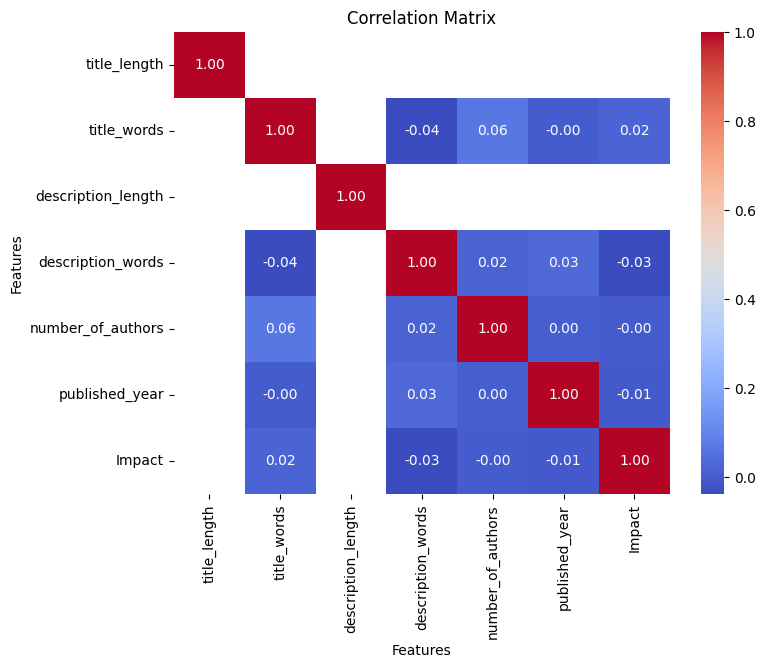

In [403]:
# Create a Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_pd, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title("Correlation Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

In [454]:
from pyspark.sql.functions import explode, split
from wordcloud import WordCloud
from pyspark.ml.feature import StopWordsRemover

In [466]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- word: string (nullable = true)



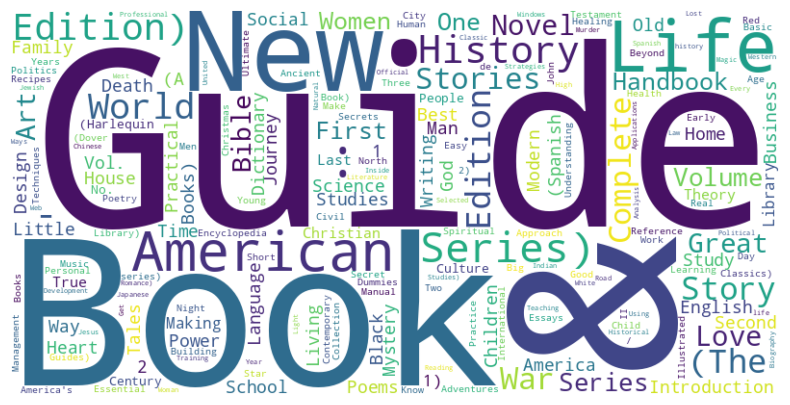

In [456]:
# Tokenize the text
df = df.withColumn("words", split(df["Title"], " "))

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

# Explode the filtered words into separate rows
df = df.select("_c0", explode("filtered_words").alias("word"))

# Count the frequency of each word
word_counts = df.groupBy("word").count().collect()

# Convert word counts to dictionary
word_freq = {row["word"]: row["count"] for row in word_counts}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [475]:
# Tokenize the text
df = df.withColumn("words", split(df["Description"], " "))

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

# Explode the filtered words into separate rows
df = df.select("_c0", explode("filtered_words").alias("word"))

# Count the frequency of each word
word_counts = df.groupBy("word").count().collect()

# Convert word counts to dictionary
word_freq = {row["word"]: row["count"] for row in word_counts}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

24/04/22 11:30:17 ERROR Executor: Exception in task 7.0 in stage 264.0 (TID 539)
org.apache.spark.SparkException: Failed to execute user defined function (StopWordsRemover$$Lambda$4265/0x000000084153f040: (array<string>) => array<string>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:136)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.sca

Py4JJavaError: An error occurred while calling o1981.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 264.0 failed 1 times, most recent failure: Lost task 7.0 in stage 264.0 (TID 539) (192.168.29.206 executor driver): org.apache.spark.SparkException: Failed to execute user defined function (StopWordsRemover$$Lambda$4265/0x000000084153f040: (array<string>) => array<string>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:136)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.NullPointerException
	at org.apache.spark.ml.feature.StopWordsRemover.$anonfun$transform$5(StopWordsRemover.scala:164)
	... 16 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function (StopWordsRemover$$Lambda$4265/0x000000084153f040: (array<string>) => array<string>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:136)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.NullPointerException
	at org.apache.spark.ml.feature.StopWordsRemover.$anonfun$transform$5(StopWordsRemover.scala:164)
	... 16 more
